# Advanced Dataset preparation with chunking


In [2]:
import os
import transformers
from datasets import load_dataset

data_path = "kyujinpy/KOR-OpenOrca-Platypus-v3"

if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    data = load_dataset("json", data_files=data_path)
else:
    data = load_dataset(data_path)    

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


<br>

## 1. Basic EDA (Exploratory Data Analysis)
---

Understanding the characteristics of your dataset remains important. For example, even if the model supports a long context such as 128k, if the average dataset text length is 50, you should perform chuking or consider a context model of 4k or less.

In [4]:
import pandas as pd
df = pd.DataFrame(data['train'])
df.head(3)

,id,input,output,instruction
0,ko_platypus.0,,"모든 가능한 결과의 확률의 합이 1$이므로, 스피너가 $C$에 착륙할 확률을 구하려...","보드 게임 스피너는 $A$, $B$, $C$로 표시된 세 부분으로 나뉩니다. 스피너..."
1,ko_platypus.1,,14명 중 6명을 선택해야 하는데 순서는 중요하지 않습니다. 이것은 순열 문제가 아...,저희 학교 수학 클럽에는 남학생 6명과 여학생 8명이 있습니다. 주 수학 경시대회...


### Basic statistics

In [6]:
df['instruction_length'] = df['instruction'].apply(len)
df['output_length'] = df['output'].apply(len)
print(df.describe())
df.head(3)

       instruction_length  output_length
count        34214.000000   34214.000000
mean           368.560589     459.279535
std            759.650286     519.266724
min             10.000000       0.000000
25%             77.000000     137.000000
50%            135.000000     311.000000
75%            353.000000     598.000000
max          18475.000000    8375.000000


,id,input,output,instruction,instruction_length,output_length
0,ko_platypus.0,,"모든 가능한 결과의 확률의 합이 1$이므로, 스피너가 $C$에 착륙할 확률을 구하려...","보드 게임 스피너는 $A$, $B$, $C$로 표시된 세 부분으로 나뉩니다. 스피너...",157,382
1,ko_platypus.1,,14명 중 6명을 선택해야 하는데 순서는 중요하지 않습니다. 이것은 순열 문제가 아...,저희 학교 수학 클럽에는 남학생 6명과 여학생 8명이 있습니다. 주 수학 경시대회...,109,166
2,ko_platypus.2,,먼저 단어에 제한을 두지 않고 4글자로 된 모든 단어의 개수를 세어봅니다. 그런 다...,"자음이 하나 이상인 4글자 단어는 $A$, $B$, $C$, $D$, $E$로 몇 ...",129,330


### Visualize sentence length

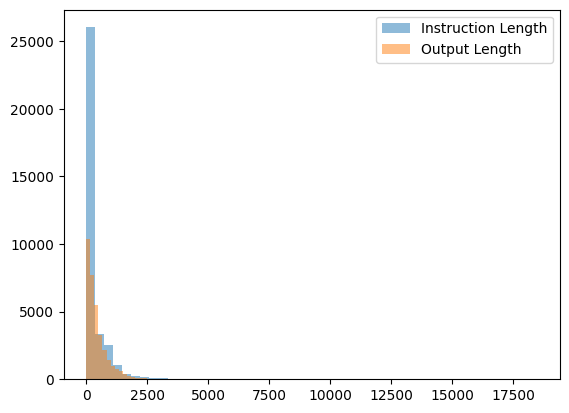

In [7]:
import matplotlib.pyplot as plt

plt.hist(df['instruction_length'], bins=50, alpha=0.5, label='Instruction Length')
plt.hist(df['output_length'], bins=50, alpha=0.5, label='Output Length')
plt.legend(loc='upper right')
plt.show()

### Unique words and frequency analysis

In [30]:
from collections import Counter

# Separate every sentence into words
all_words = ' '.join(df['instruction']).split()

# Calculate word frequency
word_freq = Counter(all_words)

# The 10 most frequently occurring words
print('The 10 most frequently occurring words: ', word_freq.most_common(10))
# The 10 most rare words
print('The 10 most rare words: ', word_freq.most_common()[:-11:-1])

The 10 most frequently occurring words:  [('-', 27061), ('수', 25124), ('이', 21921), ('있습니다.', 19122), ('=', 17278), ('있는', 12055), ('대한', 10362), ('두', 10226), ('다음', 9526), ('+', 9234)]
The 10 most rare words:  [('세굴이', 1), ('보존이', 1), ('초목의', 1), ('파괴합니다', 1), ('초목을', 1), ('파이어리츠', 1), ('애틀랜틱스', 1), ("몰'은", 1), ('능선과', 1), ('침식되기', 1)]


<br>

## 2. Data preprocessing w/ chunking
---

**Chuunking** is the process of extracting phrases or “chunks” from unstructured text. While tokenization splits text into individual words, chunking aims to extract meaningful phrases or grammatical units (e.g. noun phrases, verb phrases).

Tokenization and chunking are both techniques for text segmentation, but they serve different purposes and are useful for different NLP tasks. Tokenization is generally simpler and faster, but chunking provides deeper understanding. Additionally, tokenization is the process of dividing text into the smallest units, while chunking is the process of grouping these tokens into units with greater meaning or structure.

In [9]:
from random import randint
from itertools import chain
from functools import partial

# template dataset to add prompt to each sample
def template_dataset(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point.get("input"),
        data_point["output"],
    )
    data_point['text'] = full_prompt
    return data_point

def chunk(sample, chunk_length=2048):
    # define global remainder variable to save remainder from batches to use in next batch
    global remainder
    # Concatenate all texts and add remainder from previous batch
    concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
    concatenated_examples = {k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()}
    # get total number of tokens for batch
    batch_total_length = len(concatenated_examples[list(sample.keys())[0]])

    # get max number of chunks for batch
    if batch_total_length >= chunk_length:
        batch_chunk_length = (batch_total_length // chunk_length) * chunk_length

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)]
        for k, t in concatenated_examples.items()
    }
    # add remainder to global variable for next batch
    remainder = {k: concatenated_examples[k][batch_chunk_length:] for k in concatenated_examples.keys()}
    # prepare labels
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
import json
import os.path as osp
from typing import Union

class Prompter(object):
    __slots__ = ("template", "_verbose")

    def __init__(self, template_name: str = "", verbose: bool = False):
        self._verbose = verbose
        if not template_name:
            # Enforce the default here, so the constructor can be called with '' and will not break.
            template_name = "alpaca"
        file_name = osp.join("./templates", f"{template_name}.json")
        if not osp.exists(file_name):
            raise ValueError(f"Can't read {file_name}")
        with open(file_name) as fp:
            self.template = json.load(fp)
        if self._verbose:
            print(
                f"Using prompt template {template_name}: {self.template['description']}"
            )

    def generate_prompt(
        self,
        instruction: str,
        input: Union[None, str] = None,
        label: Union[None, str] = None,
    ) -> str:
        # returns the full prompt from instruction and optional input
        # if a label (=response, =output) is provided, it's also appended.
        if input:
            res = self.template["prompt_input"].format(
                instruction=instruction, input=input
            )
        else:
            res = self.template["prompt_no_input"].format(
                instruction=instruction
            )
        if label:
            res = f"{res}{label}"
        if self._verbose:
            print(res)
        return res

    def get_response(self, output: str) -> str:
        return output.split(self.template["response_split"])[1].strip()

### Load prompt template and tokenizer

Many toolkits, including TRL, preprocess the raw text for you, but in some situations it is necessary to perform tokenization beforehand and store the tokenized vector data in storage.

In [21]:
from transformers import AutoTokenizer
HF_MODEL_ID = "microsoft/Phi-3-mini-4k-instruct"
prompter = Prompter("alpaca_ko")
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_ID)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
dataset = data['train'].shuffle()#.select(range(200))
dataset = dataset.map(template_dataset, remove_columns=list(dataset.features))

# empty list to save remainder from batches to use in next batch
remainder = {"input_ids": [], "attention_mask": []}

# tokenize and chunk dataset
lm_dataset = dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(dataset.features)
).map(
    partial(chunk, chunk_length=1536),
    batched=True,
)

# Print total number of samples
print(f"Total number of samples: {len(lm_dataset)}")

Map: 100%|██████████| 34214/34214 [00:45<00:00, 750.45 examples/s]

Total number of samples: 26684


### Check chunked data

In [23]:
df_lm = lm_dataset.to_pandas()
df_lm.head(5)

,input_ids,attention_mask,labels
0,"[1, 29871, 30860, 238, 161, 155, 31081, 29871,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 29871, 30860, 238, 161, 155, 31081, 29871,..."
1,"[30811, 30811, 31826, 29892, 29871, 238, 182, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30811, 30811, 31826, 29892, 29871, 238, 182, ..."
2,"[191, 30393, 29871, 240, 156, 131, 30826, 2987...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[191, 30393, 29871, 240, 156, 131, 30826, 2987..."
3,"[29871, 29947, 30393, 238, 147, 155, 31136, 23...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[29871, 29947, 30393, 238, 147, 155, 31136, 23..."
4,"[30393, 31137, 29892, 285, 29898, 29873, 29892...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30393, 31137, 29892, 285, 29898, 29873, 29892..."


Store the length of each vector in the 'input_ids' column in a new column 'input_ids_length'

In [31]:
df_lm['input_ids_length'] = df_lm['input_ids'].apply(len)
df_lm.head()

,input_ids,attention_mask,labels,input_ids_length
0,"[1, 29871, 30860, 238, 161, 155, 31081, 29871,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 29871, 30860, 238, 161, 155, 31081, 29871,...",1536
1,"[30811, 30811, 31826, 29892, 29871, 238, 182, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30811, 30811, 31826, 29892, 29871, 238, 182, ...",1536
2,"[191, 30393, 29871, 240, 156, 131, 30826, 2987...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[191, 30393, 29871, 240, 156, 131, 30826, 2987...",1536
3,"[29871, 29947, 30393, 238, 147, 155, 31136, 23...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[29871, 29947, 30393, 238, 147, 155, 31136, 23...",1536
4,"[30393, 31137, 29892, 285, 29898, 29873, 29892...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30393, 31137, 29892, 285, 29898, 29873, 29892...",1536


Note that the maximum length of the chunking vector is fixed to the set chunk_length windowing size.

In [25]:
max_value = df_lm['input_ids_length'].max()
print(f"The maximum length of 'input_ids' is {max_value}")

The maximum length of 'input_ids' is 1536


### Save pre-processed dataset to storage

In [28]:
# num_debug_samples = 50
DATA_DIR = "chunked_dataset"
lm_dataset.save_to_disk(DATA_DIR)

Saving the dataset (2/2 shards): 100%|██████████| 26684/26684 [00:03<00:00, 7318.14 examples/s] 
